<h2 align = "center">Mod 6: Bias</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import latte
import latte.nn as nn
import latte.optim as optim
import latte.functional as F
import latte.utils.data as data

import lattevision as lv
import lattevision.datasets as dsets
import lattevision.transforms as T


In [2]:
mnist_root = '../data/mnist'
mnist_transform = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

mnist_train = dsets.MNIST(mnist_root, train=True, transform=mnist_transform)
mnist_test = dsets.MNIST(mnist_root, train=False, transform=mnist_transform)

val_len = len(mnist_train) // 10
train_len = len(mnist_train) - val_len
mnist_train, mnist_val = data.random_split(mnist_train, [train_len, val_len])

train_batch_size = 128
test_batch_size = 512

train_loader = data.DataLoader(mnist_train, batch_size=train_batch_size, shuffle=True)
val_loader = data.DataLoader(mnist_val, batch_size=train_batch_size, shuffle=False)
test_loader = data.DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False)


In [3]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

class ModelNoBias(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10, bias=False)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


model = Model()
model_nobias = ModelNoBias()
criterion = nn.CrossEntropyLoss()
criterion_nobias = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0)
optimizer_nobias = optim.SGD(model_nobias.parameters(), lr=1e-2, momentum=0)


In [4]:
max_epochs = 15

train_losses = []
train_losses_nobias = []
train_accuracies = []
train_accuracies_nobias = []

val_losses = []
val_losses_nobias = []
val_accuracies = []
val_accuracies_nobias = []

for epoch in range(max_epochs):
    # Training
    epoch_loss = 0
    epoch_loss_nobias = 0
    epoch_accuracy = 0
    epoch_accuracy_nobias = 0
    epoch_batchs = 0

    for ii, (data, target) in enumerate(train_loader):
        batch_size = data.shape[0]
        if batch_size != train_batch_size:
            continue
        epoch_batchs += 1

        data = latte.Tensor(data.reshape(batch_size, -1))
        target = latte.Tensor(target)

        # Forward pass
        optimizer.zero_grad()
        optimizer_nobias.zero_grad()
        output = model(data)
        output_nobias = model_nobias(data)

        # Compute loss
        loss = criterion(output, target)
        epoch_loss += loss.data
        loss_nobias = criterion_nobias(output_nobias, target)
        epoch_loss_nobias += loss_nobias.data

        # Backward pass
        loss.backward()
        optimizer.step()
        loss_nobias.backward()
        optimizer_nobias.step()

        # Compute accuracy
        accuracy = (output.data.argmax(axis=1) == target.data).mean()
        epoch_accuracy += accuracy
        accuracy_nobias = (output_nobias.data.argmax(axis=1) == target.data).mean()
        epoch_accuracy_nobias += accuracy_nobias

    # Logging
    train_losses.append(np.round(epoch_loss / epoch_batchs, 4))
    train_losses_nobias.append(np.round(epoch_loss_nobias / epoch_batchs, 4))
    train_accuracies.append(np.round(epoch_accuracy / epoch_batchs, 4))
    train_accuracies_nobias.append(np.round(epoch_accuracy_nobias / epoch_batchs, 4))

    # Validation
    epoch_loss = 0
    epoch_loss_nobias = 0
    epoch_accuracy = 0
    epoch_accuracy_nobias = 0
    epoch_batchs = 0
    
    for data, target in val_loader:
        batch_size = data.shape[0]
        if batch_size != train_batch_size:
            continue
        epoch_batchs += 1

        data = latte.Tensor(data.reshape(batch_size, -1))
        target = latte.Tensor(target)

        output = model(data)
        output_nobias = model_nobias(data)

        # Compute loss
        loss = criterion(output, target)
        epoch_loss += loss.data
        loss_nobias = criterion_nobias(output_nobias, target)
        epoch_loss_nobias += loss_nobias.data

        # Compute accuracy
        accuracy = (output.data.argmax(axis=1) == target.data).mean()
        epoch_accuracy += accuracy
        accuracy_nobias = (output_nobias.data.argmax(axis=1) == target.data).mean()
        epoch_accuracy_nobias += accuracy_nobias

    # Logging
    val_losses.append(np.round(epoch_loss / epoch_batchs, 4))
    val_losses_nobias.append(np.round(epoch_loss_nobias / epoch_batchs, 4))
    val_accuracies.append(np.round(epoch_accuracy / epoch_batchs, 4))
    val_accuracies_nobias.append(np.round(epoch_accuracy_nobias / epoch_batchs, 4))

print('Bias:')
print('Training')
print(f'\tLoss: {train_losses}')
print(f'\tAccuracy: {train_accuracies}')
print('Validation')
print(f'\tLoss: {val_losses}')
print(f'\tAccuracy: {val_accuracies}')
print('No Bias:')
print('Training')
print(f'\tLoss: {train_losses_nobias}')
print(f'\tAccuracy: {train_accuracies_nobias}')
print('Validation')
print(f'\tLoss: {val_losses_nobias}')
print(f'\tAccuracy: {val_accuracies_nobias}')


Bias:
Training
	Loss: [1.2237, 0.4417, 0.3534, 0.3166, 0.292, 0.2732, 0.2569, 0.2424, 0.2296, 0.2182, 0.208, 0.1983, 0.1895, 0.1814, 0.1742]
	Accuracy: [0.7434, 0.8818, 0.9003, 0.9092, 0.9162, 0.9216, 0.9264, 0.9312, 0.9345, 0.9383, 0.9417, 0.9442, 0.9466, 0.9489, 0.9511]
Validation
	Loss: [0.5571, 0.403, 0.3566, 0.3292, 0.3097, 0.2937, 0.2772, 0.2635, 0.253, 0.241, 0.2326, 0.2225, 0.2145, 0.207, 0.1996]
	Accuracy: [0.8552, 0.8852, 0.8997, 0.9049, 0.9102, 0.9125, 0.9168, 0.9205, 0.9243, 0.9299, 0.9306, 0.934, 0.9372, 0.9396, 0.9422]
No Bias:
Training
	Loss: [1.2374, 0.4429, 0.3549, 0.3186, 0.2947, 0.2766, 0.261, 0.247, 0.2344, 0.2231, 0.2128, 0.2029, 0.1938, 0.1855, 0.1779]
	Accuracy: [0.7435, 0.8819, 0.8997, 0.9088, 0.9153, 0.9207, 0.925, 0.9297, 0.9333, 0.9367, 0.9394, 0.9425, 0.9452, 0.9474, 0.9497]
Validation
	Loss: [0.5589, 0.4047, 0.3579, 0.3309, 0.3117, 0.2965, 0.2807, 0.2675, 0.2573, 0.2456, 0.2372, 0.2271, 0.219, 0.2114, 0.2043]
	Accuracy: [0.8554, 0.8872, 0.8995, 0.905, 0.909

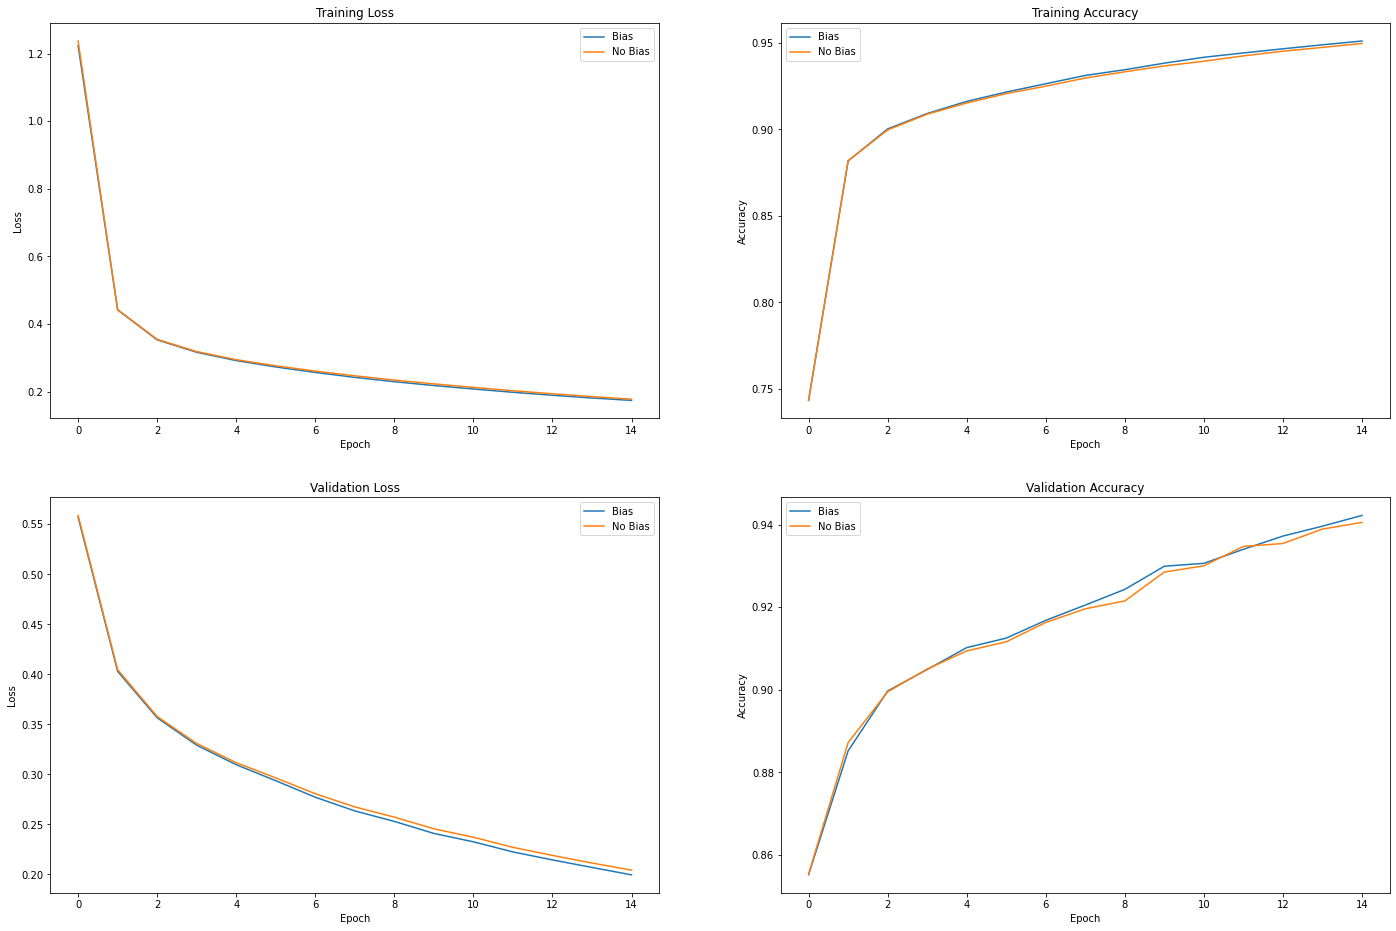

In [5]:
# Plot
plt.figure(figsize=(24, 16))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Bias')
plt.plot(train_losses_nobias, label='No Bias')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Bias')
plt.plot(train_accuracies_nobias, label='No Bias')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(val_losses, label='Bias')
plt.plot(val_losses_nobias, label='No Bias')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(val_accuracies, label='Bias')
plt.plot(val_accuracies_nobias, label='No Bias')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [6]:
# Test
correct = 0
correct_nobias = 0
total = 0
for data, target in test_loader:
    batch_size = data.shape[0]
    if batch_size != test_batch_size:
        continue

    data = latte.Tensor(data.reshape(batch_size, -1))
    target = latte.Tensor(target)

    output = model(data)
    output_nobias = model_nobias(data)
    correct += (output.data.argmax(axis=1) == target.data).sum()
    correct_nobias += (output_nobias.data.argmax(axis=1) == target.data).sum()
    total += target.shape[0]

print(f'Accuracy')
print(f'\tBias: {(correct / total): .4f}')
print(f'\tNo Bias: {(correct_nobias / total): .4f}')


Accuracy
	Bias:  0.9524
	No Bias:  0.9500
